### Load Libraries

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import adam_v2
from keras.models import load_model, Model, Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,Input,BatchNormalization,GRU, Average
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import warnings
warnings.filterwarnings('ignore')

### Loading datasets

In [222]:
# Load data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
challenges = pd.read_csv('data/challenge_data.csv')

##### Train Data

In [223]:
train.head()

,user_sequence,user_id,challenge_sequence,challenge
0,4576_1,4576,1,CI23714
1,4576_2,4576,2,CI23855
2,4576_3,4576,3,CI24917
3,4576_4,4576,4,CI23663
4,4576_5,4576,5,CI23933


In [224]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903916 entries, 0 to 903915
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   user_sequence       903916 non-null  object
 1   user_id             903916 non-null  int64 
 2   challenge_sequence  903916 non-null  int64 
 3   challenge           903916 non-null  object
dtypes: int64(2), object(2)
memory usage: 27.6+ MB


In [225]:
print('Shape of train dataset: ', train.shape)

Shape of train dataset:  (903916, 4)


##### Test Data

In [6]:
test.head()

,user_sequence,user_id,challenge_sequence,challenge
0,4577_1,4577,1,CI23855
1,4577_2,4577,2,CI23933
2,4577_3,4577,3,CI24917
3,4577_4,4577,4,CI24915
4,4577_5,4577,5,CI23714


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397320 entries, 0 to 397319
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   user_sequence       397320 non-null  object
 1   user_id             397320 non-null  int64 
 2   challenge_sequence  397320 non-null  int64 
 3   challenge           397320 non-null  object
dtypes: int64(2), object(2)
memory usage: 12.1+ MB


In [8]:
print('Shape of test dataset: ', test.shape)

Shape of test dataset:  (397320, 4)


##### Challenges

In [9]:
challenges.head()

,challenge_ID,programming_language,challenge_series_ID,total_submissions,publish_date,author_ID,author_gender,author_org_ID,category_id
0,CI23478,2,SI2445,37.0,06-05-2006,AI563576,M,AOI100001,NaN
1,CI23479,2,SI2435,48.0,17-10-2002,AI563577,M,AOI100002,32.0
2,CI23480,1,SI2435,15.0,16-10-2002,AI563578,M,AOI100003,NaN
3,CI23481,1,SI2710,236.0,19-09-2003,AI563579,M,AOI100004,70.0
4,CI23482,2,SI2440,137.0,21-03-2002,AI563580,M,AOI100005,NaN


In [10]:
challenges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   challenge_ID          5606 non-null   object 
 1   programming_language  5606 non-null   int64  
 2   challenge_series_ID   5594 non-null   object 
 3   total_submissions     5254 non-null   float64
 4   publish_date          5606 non-null   object 
 5   author_ID             5567 non-null   object 
 6   author_gender         5509 non-null   object 
 7   author_org_ID         5358 non-null   object 
 8   category_id           3765 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 394.3+ KB


In [11]:
print('Shape of challenges dataset: ', challenges.shape)

Shape of challenges dataset:  (5606, 9)


In [90]:
# unique values in columns (NaN is not included)
challenges.nunique()

challenge_ID            5606
programming_language       3
challenge_series_ID      435
total_submissions       1067
publish_date            1145
author_ID               3484
author_gender              2
author_org_ID           1717
category_id              194
dtype: int64

In [238]:
# Extract year, month, week day from publish_date
challenges['publish_date'] = pd.to_datetime(challenges['publish_date']).dt.strftime("%d.%m.%Y")
challenges['year'] = pd.to_datetime(challenges['publish_date']).dt.year
challenges['month'] = pd.to_datetime(challenges['publish_date']).dt.month
challenges['week_day'] = pd.to_datetime(challenges['publish_date']).dt.day_name(locale = 'English')

In [239]:
challenges

,challenge_ID,programming_language,challenge_series_ID,total_submissions,publish_date,author_ID,author_gender,author_org_ID,category_id,year,month,week_day
0,CI23478,2,SI2445,37.0,05.06.2006,AI563576,M,AOI100001,NaN,2006,5,Saturday
1,CI23479,2,SI2435,48.0,17.10.2002,AI563577,M,AOI100002,32.0,2002,10,Thursday
2,CI23480,1,SI2435,15.0,16.10.2002,AI563578,M,AOI100003,NaN,2002,10,Wednesday
3,CI23481,1,SI2710,236.0,19.09.2003,AI563579,M,AOI100004,70.0,2003,9,Friday
4,CI23482,2,SI2440,137.0,21.03.2002,AI563580,M,AOI100005,NaN,2002,3,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...
5601,CI29079,1,SI2864,NaN,17.06.2010,AI567059,M,AOI101717,29.0,2010,6,Thursday
5602,CI29080,1,SI2865,NaN,25.06.2010,AI567060,F,AOI101718,29.0,2010,6,Friday
5603,CI29081,1,SI2865,NaN,25.06.2010,AI566257,M,AOI100108,29.0,2010,6,Friday
5604,CI29082,1,SI2865,NaN,25.06.2010,AI563777,M,AOI100108,29.0,2010,6,Friday


In [147]:
from pandas.api.types import CategoricalDtype
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
challenges['week_day'] = challenges['week_day'].astype(cat_type)

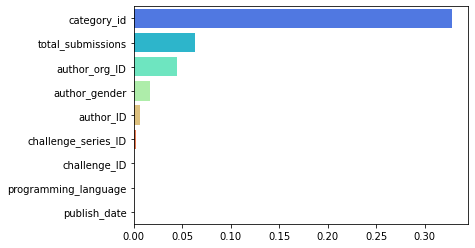

In [68]:
# Check the null values (in percentages %)
null_val = challenges.isnull().sum()/challenges.shape[0]
null_val.sort_values(inplace=True, ascending=False, )
palette=sns.color_palette("rainbow")
sns.barplot(x=null_val, y=null_val.index, palette=palette);

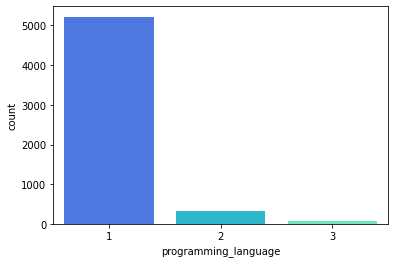

In [91]:
# programming languages
sns.countplot(x='programming_language', 
              data=challenges, 
              palette=palette);

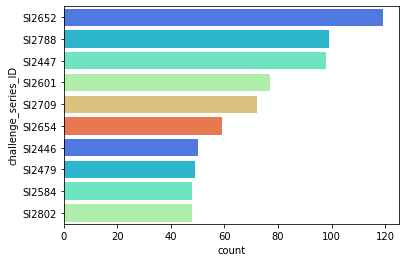

In [81]:
# top 10 challenge series
sns.countplot(y='challenge_series_ID', 
              data=challenges, 
              order = challenges['challenge_series_ID'].value_counts().index[:10],
              palette=palette);

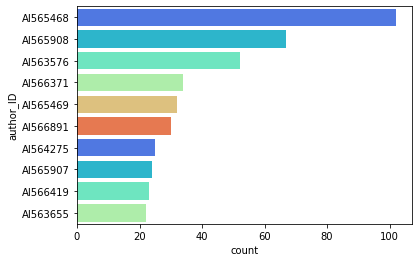

In [82]:
# top 10 authors
sns.countplot(y='author_ID', 
              data=challenges, 
              order = challenges['author_ID'].value_counts().index[:10],
              palette=palette);

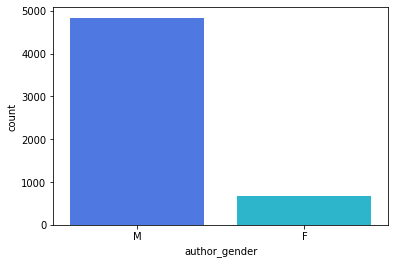

In [85]:
# authors gender
sns.countplot(x='author_gender', 
              data=challenges, 
              palette=palette);

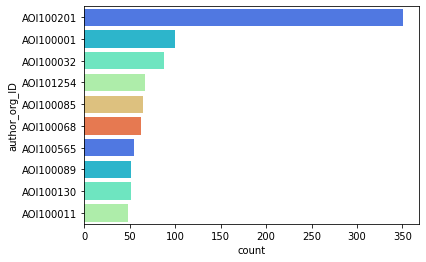

In [95]:
# top 10 Organization ID for authors
sns.countplot(y='author_org_ID', 
              data=challenges, 
              order = challenges['author_org_ID'].value_counts().index[:10],
              palette=palette);

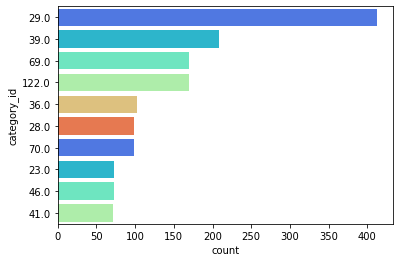

In [98]:
# top 10 categories of challenges
sns.countplot(y='category_id', 
              data=challenges, 
              order = challenges['category_id'].value_counts().index[:10],
              palette=palette);

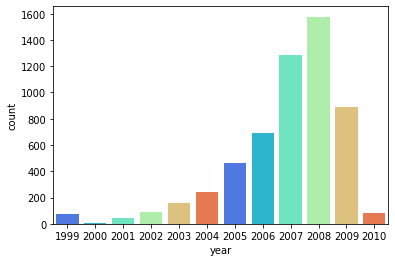

In [129]:
# Challenges by Year
sns.countplot(x='year', 
              data=challenges,
              palette=palette);

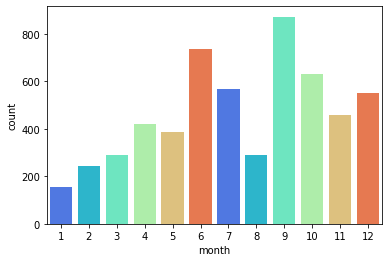

In [130]:
# Challenges by Month
sns.countplot(x='month', 
              data=challenges,
              palette=palette);

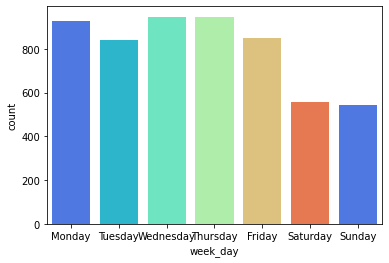

In [153]:
# Challenges by Week Day
sns.countplot(x='week_day', 
              data=challenges,
              palette=palette);

In [165]:
# fraction of train challenges to all challenges
train['challenge'].nunique()/challenges['challenge_ID'].nunique()

0.953977880841955

In [167]:
# fraction of test challenges to all challenges
test['challenge'].nunique()/challenges['challenge_ID'].nunique()

0.7986086336068497

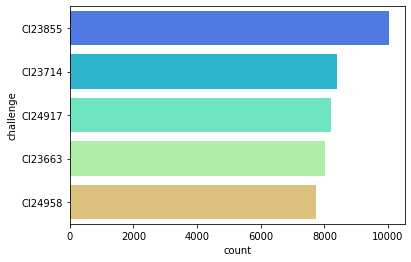

In [240]:
# Most frequent challenges in train dataset
sns.countplot(y='challenge', 
              data=train,
              order = train['challenge'].value_counts().index[:5],
              palette=palette);

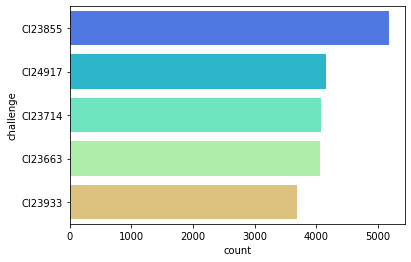

In [241]:
#  Most frequent challenges in test dataset
sns.countplot(y='challenge', 
              data=test,
              order = test['challenge'].value_counts().index[:5],
              palette=palette);

In [190]:
all_challenges = challenges['challenge_ID'].unique()
train_challenge = train['challenge'].unique()
test_challenges = test['challenge'].unique()

In [197]:
train_intersect = np.intersect1d(all_challenges,train_challenge)
train_setdiff = np.setdiff1d(all_challenges,train_challenge)

In [196]:
test_intersect = np.intersect1d(all_challenges,test_challenges)
test_setdiff = np.setdiff1d(all_challenges,test_challenges)

In [217]:
# challenges that are in train set but not in test
train_test_setdiff = np.setdiff1d(train_challenge, test_challenges)
train_test_setdiff.shape

(1025,)

In [204]:
# Challenges that are not in test and train set
np.setdiff1d(train_setdiff, test_setdiff).shape

(154,)

In [216]:
test[test['challenge']=='CI23488']

,user_sequence,user_id,challenge_sequence,challenge


### Encode Challenges

In [226]:
# Encode challenges
encoder = LabelEncoder()
encoder.fit(challenges['challenge_ID'])

train['challenge_encoded'] = encoder.transform(train['challenge'])
train.sort_values('challenge_encoded')

,user_sequence,user_id,challenge_sequence,challenge,challenge_encoded
696115,88820_5,88820,5,CI23478,0
233991,32876_5,32876,5,CI23478,0
766721,97359_8,97359,8,CI23478,0
764979,97150_8,97150,8,CI23478,0
627507,80527_11,80527,11,CI23479,1
...,...,...,...,...,...
558993,72288_7,72288,7,CI29082,5604
517989,67346_5,67346,5,CI29082,5604
793952,100602_4,100602,4,CI29083,5605
393574,52222_13,52222,13,CI29083,5605


In [227]:
# challenges 1-10 
temp = train[train.challenge_sequence <= 10]
# group challenges(1-10) in one column 
df = temp.groupby('user_id')["challenge_encoded"].agg(lambda x:list(x.values)).reset_index()

In [228]:
# challenges 11-13
next_challenge = train[train.challenge_sequence > 10][['user_id','challenge_encoded']]
next_challenge.rename(columns={'challenge_encoded':'next_challenge'},inplace=True)

# merge 2 df
df = df.merge(next_challenge)

In [242]:
df.head()

,user_id,challenge_encoded,next_challenge
0,4576,"[236, 377, 1439, 185, 455, 1657, 497, 1648, 14...",1480
1,4576,"[236, 377, 1439, 185, 455, 1657, 497, 1648, 14...",189
2,4576,"[236, 377, 1439, 185, 455, 1657, 497, 1648, 14...",213
3,4580,"[185, 377, 455, 497, 1052, 236, 170, 303, 189,...",1437
4,4580,"[185, 377, 455, 497, 1052, 236, 170, 303, 189,...",2249


### Create x_train, y_train, x_validation, y_validation

In [229]:
# Split data to train and valid sets
df_train, df_validation = train_test_split(df.sample(frac=1,random_state=123), test_size = 0.04, random_state=123)

In [230]:
print('shape df_train: ', df_train.shape)
print('shape df_validation: ', df_validation.shape)

shape df_train:  (200252, 3)
shape df_validation:  (8344, 3)


In [231]:
x_train_np_list = df_train['challenge_encoded'].values # have bad format np array-list-np array
x_train = np.array(list(x_train_np_list))

x_valid_np_list = df_validation['challenge_encoded'].values # have bad format np array-list-np array
x_valid = np.array(list(x_valid_np_list))

y_train = df_train['next_challenge'].values
y_valid = df_validation['next_challenge'].values

In [232]:
TOTAL_WORDS = challenges['challenge_ID'].nunique()
SEQUENCE_LEN = 10  # 10 challenges 
N_CATEGORIES = challenges.shape[0]  # number of all possible challenges (5606)

In [14]:
challenges['challenge_ID'].nunique()

5606

### Define & Train model 

In [14]:
# Model callbacks

# reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.05, patience=5,  verbose = 0)

# defining callback list
callback_list = [reduce_lr]

In [15]:
inp = Input(shape=(SEQUENCE_LEN))
x = Embedding(TOTAL_WORDS,512)(inp)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(512, dropout=0.1, recurrent_dropout=0.1))(x) #return_sequences=True
x = Dropout(0.4)(x)
x = Dense(N_CATEGORIES, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.summary()

In [88]:
optimizer = adam_v2.Adam(learning_rate=0.00001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [89]:
# Fit the model
model.fit(x_train,
          y_train,
          epochs=5,
          batch_size=1024,
          validation_data=(x_valid, y_valid)
          #callbacks = callback_list
         )

Epoch 1/5
196/196 [==============================] - 33s 136ms/step - loss: 1.7662 - accuracy: 0.3314 - val_loss: 5.8690 - val_accuracy: 0.0022
Epoch 2/5
196/196 [==============================] - 25s 127ms/step - loss: 1.7706 - accuracy: 0.3291 - val_loss: 5.8711 - val_accuracy: 0.0020
Epoch 3/5
196/196 [==============================] - 25s 128ms/step - loss: 1.7625 - accuracy: 0.3309 - val_loss: 5.8730 - val_accuracy: 0.0023
Epoch 4/5
196/196 [==============================] - 25s 128ms/step - loss: 1.7624 - accuracy: 0.3328 - val_loss: 5.8748 - val_accuracy: 0.0020
Epoch 5/5
196/196 [==============================] - 25s 128ms/step - loss: 1.7639 - accuracy: 0.3306 - val_loss: 5.8770 - val_accuracy: 0.0019


In [94]:
# model.save_weights('weights1.hdf5')
# model.save("models/model.h5")

### Define & Train model1

In [57]:
inp = Input(shape=(SEQUENCE_LEN))
x = Embedding(TOTAL_WORDS,512)(inp)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(256, dropout=0.1, recurrent_dropout=0.1))(x)
x = Dropout(0.1)(x)
x = Dense(N_CATEGORIES, activation="softmax")(x)
model1 = Model(inputs=inp, outputs=x)

# model1.summary()

In [95]:
optimizer = adam_v2.Adam(learning_rate=0.00001)
model1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [97]:
# Fit the model
model1.fit(x_train,
          y_train,
          epochs=5,
          batch_size=1024,
          validation_data=(x_valid, y_valid),
          callbacks = callback_list
         )

Epoch 1/5
196/196 [==============================] - 21s 107ms/step - loss: 1.8452 - accuracy: 0.3200 - val_loss: 5.2774 - val_accuracy: 0.0122
Epoch 2/5
196/196 [==============================] - 21s 107ms/step - loss: 1.8438 - accuracy: 0.3211 - val_loss: 5.2789 - val_accuracy: 0.0121
Epoch 3/5
196/196 [==============================] - 21s 107ms/step - loss: 1.8423 - accuracy: 0.3215 - val_loss: 5.2804 - val_accuracy: 0.0119
Epoch 4/5
196/196 [==============================] - 21s 106ms/step - loss: 1.8428 - accuracy: 0.3196 - val_loss: 5.2819 - val_accuracy: 0.0117
Epoch 5/5
196/196 [==============================] - 21s 106ms/step - loss: 1.8401 - accuracy: 0.3221 - val_loss: 5.2838 - val_accuracy: 0.0117


In [76]:
# model1.save_weights('weights2.hdf5')
# model1.save("models/model1.h5")

### Define & Train model2

In [77]:
inp = Input(shape=(SEQUENCE_LEN))
x = Embedding(TOTAL_WORDS,512)(inp)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(512, dropout=0.1, recurrent_dropout=0.1))(x)
x = Dropout(0.4)(x)
x = Dense(N_CATEGORIES, activation="softmax")(x)
model2 = Model(inputs=inp, outputs=x)

# model2.summary()

In [102]:
optimizer = adam_v2.Adam(learning_rate=0.0001)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [103]:
# Fit the model
model2.fit(x_train,
          y_train,
          epochs=5,
          batch_size=1024,
          validation_data=(x_valid, y_valid),
          callbacks = callback_list
         )

Epoch 1/5
196/196 [==============================] - 34s 136ms/step - loss: 1.8733 - accuracy: 0.3184 - val_loss: 5.5577 - val_accuracy: 0.0042
Epoch 2/5
196/196 [==============================] - 25s 127ms/step - loss: 1.8740 - accuracy: 0.3185 - val_loss: 5.5732 - val_accuracy: 0.0037
Epoch 3/5
196/196 [==============================] - 25s 127ms/step - loss: 1.8601 - accuracy: 0.3203 - val_loss: 5.5857 - val_accuracy: 0.0035
Epoch 4/5
196/196 [==============================] - 25s 126ms/step - loss: 1.8610 - accuracy: 0.3183 - val_loss: 5.6024 - val_accuracy: 0.0036
Epoch 5/5
196/196 [==============================] - 25s 127ms/step - loss: 1.8489 - accuracy: 0.3216 - val_loss: 5.6154 - val_accuracy: 0.0034


In [108]:
# model2.save("models/model2.h5")
# model2.save_weights('weights3.hdf5')

### Define & Train model3

In [109]:
inp = Input(shape=(SEQUENCE_LEN))
x = Embedding(TOTAL_WORDS,512)(inp)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(512, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(512))(x)
x = Dense(N_CATEGORIES, activation="softmax")(x)
model3 = Model(inputs=inp, outputs=x)

# model3.summary()

In [124]:
optimizer = adam_v2.Adam(learning_rate=0.000001)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [126]:
# Fit the model
model3.fit(x_train,
          y_train,
          epochs=5,
          batch_size=1024,
          validation_data=(x_valid, y_valid),
          callbacks = callback_list
         )

Epoch 1/5
196/196 [==============================] - 36s 182ms/step - loss: 1.2316 - accuracy: 0.3466 - val_loss: 6.2655 - val_accuracy: 1.1985e-04
Epoch 2/5
196/196 [==============================] - 35s 181ms/step - loss: 1.2324 - accuracy: 0.3454 - val_loss: 6.2659 - val_accuracy: 1.1985e-04
Epoch 3/5
196/196 [==============================] - 36s 181ms/step - loss: 1.2318 - accuracy: 0.3456 - val_loss: 6.2662 - val_accuracy: 1.1985e-04
Epoch 4/5
196/196 [==============================] - 35s 181ms/step - loss: 1.2312 - accuracy: 0.3455 - val_loss: 6.2669 - val_accuracy: 1.1985e-04
Epoch 5/5
196/196 [==============================] - 36s 182ms/step - loss: 1.2320 - accuracy: 0.3448 - val_loss: 6.2674 - val_accuracy: 1.1985e-04


In [132]:
# model3.save_weights('weights4.hdf5')
# model3.save("models/model3.h5")

### Define & Train model4

In [133]:
inp = Input(shape=(SEQUENCE_LEN))
x = Embedding(TOTAL_WORDS,512)(inp)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(512, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))(x)
x = Dropout(0.1)(x)
x = Bidirectional(GRU(512))(x)
x = Dropout(0.1)(x)
x = Dense(N_CATEGORIES, activation="softmax")(x)
model4 = Model(inputs=inp, outputs=x)

# model4.summary()

In [146]:
optimizer = adam_v2.Adam(learning_rate=0.000001)
model4.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [147]:
# Fit the model
model4.fit(x_train,
          y_train,
          epochs=5,
          batch_size=1024,
          validation_data=(x_valid, y_valid),
          callbacks = callback_list
         )

Epoch 1/5
196/196 [==============================] - 45s 179ms/step - loss: 1.5655 - accuracy: 0.3404 - val_loss: 5.3901 - val_accuracy: 0.0046
Epoch 2/5
196/196 [==============================] - 33s 168ms/step - loss: 1.5596 - accuracy: 0.3443 - val_loss: 5.3906 - val_accuracy: 0.0046
Epoch 3/5
196/196 [==============================] - 33s 168ms/step - loss: 1.5659 - accuracy: 0.3409 - val_loss: 5.3911 - val_accuracy: 0.0046
Epoch 4/5
196/196 [==============================] - 33s 168ms/step - loss: 1.5656 - accuracy: 0.3416 - val_loss: 5.3916 - val_accuracy: 0.0046
Epoch 5/5
196/196 [==============================] - 33s 168ms/step - loss: 1.5662 - accuracy: 0.3408 - val_loss: 5.3922 - val_accuracy: 0.0046


In [145]:
# model4.save_weights('weights5_3.hdf5')
# model4.save("models/model4.h5")

### Define & Train model5

In [172]:
inp = Input(shape=(SEQUENCE_LEN))
x = Embedding(TOTAL_WORDS,256)(inp)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(256))(x)
x = Dropout(0.1)(x)
x = Dense(N_CATEGORIES, activation="relu")(x)
x = Dense(N_CATEGORIES, activation="softmax")(x)
model5 = Model(inputs=inp, outputs=x)

# model5.summary()

In [176]:
optimizer = adam_v2.Adam(learning_rate=0.000001)
model5.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [177]:
# Fit the model
model5.fit(x_train,
           y_train,
           epochs=5,
           batch_size=1024,
           validation_data=(x_valid, y_valid),
           callbacks = callback_list
          )

Epoch 1/5
196/196 [==============================] - 16s 62ms/step - loss: 1.5587 - accuracy: 0.3412 - val_loss: 6.1759 - val_accuracy: 0.0062
Epoch 2/5
196/196 [==============================] - 11s 57ms/step - loss: 1.5565 - accuracy: 0.3406 - val_loss: 6.1786 - val_accuracy: 0.0062
Epoch 3/5
196/196 [==============================] - 11s 57ms/step - loss: 1.5537 - accuracy: 0.3424 - val_loss: 6.1804 - val_accuracy: 0.0062
Epoch 4/5
196/196 [==============================] - 11s 57ms/step - loss: 1.5519 - accuracy: 0.3440 - val_loss: 6.1829 - val_accuracy: 0.0064
Epoch 5/5
196/196 [==============================] - 11s 58ms/step - loss: 1.5553 - accuracy: 0.3417 - val_loss: 6.1848 - val_accuracy: 0.0064


In [170]:
# model5.save_weights('weights6.hdf5')
# model5.save("models/model5.h5")

### Define & Train model6

In [183]:
inp = Input(shape=(SEQUENCE_LEN))
x = Embedding(TOTAL_WORDS,256)(inp)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(256, dropout=0.1, recurrent_dropout=0.1))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(N_CATEGORIES*2, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(N_CATEGORIES, activation="softmax")(x)
model6 = Model(inputs=inp, outputs=x)

# model6.summary()

In [199]:
optimizer = adam_v2.Adam(learning_rate=0.0000005)
model6.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [200]:
# Fit the model
model6.fit(x_train,
           y_train,
           epochs=5,
           batch_size=1024,
           validation_data=(x_valid, y_valid),
           callbacks = callback_list
          )

Epoch 1/5
196/196 [==============================] - 38s 155ms/step - loss: 1.4787 - accuracy: 0.3425 - val_loss: 6.4831 - val_accuracy: 0.0023
Epoch 2/5
196/196 [==============================] - 29s 147ms/step - loss: 1.4819 - accuracy: 0.3408 - val_loss: 6.4818 - val_accuracy: 0.0023
Epoch 3/5
196/196 [==============================] - 29s 147ms/step - loss: 1.4743 - accuracy: 0.3448 - val_loss: 6.4846 - val_accuracy: 0.0023
Epoch 4/5
196/196 [==============================] - 29s 147ms/step - loss: 1.4749 - accuracy: 0.3424 - val_loss: 6.4870 - val_accuracy: 0.0023
Epoch 5/5
196/196 [==============================] - 29s 146ms/step - loss: 1.4790 - accuracy: 0.3431 - val_loss: 6.4865 - val_accuracy: 0.0023


In [206]:
# model6.save_weights('weights7.hdf5')
# model6.save("models/model6.h5")

### Define & Train model7

In [208]:
inp = Input(shape=(SEQUENCE_LEN))
x = Embedding(TOTAL_WORDS,500)(inp)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(500, dropout=0.1, recurrent_dropout=0.1))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(N_CATEGORIES*2, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(N_CATEGORIES, activation="softmax")(x)
model7 = Model(inputs=inp, outputs=x)

# model7.summary()

In [223]:
optimizer = adam_v2.Adam(learning_rate=0.0000001)
model7.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Fit the model
model7.fit(x_train,
           y_train,
           epochs=10,
           batch_size=1024,
           validation_data=(x_valid, y_valid),
           callbacks = callback_list
          )

Epoch 1/10
196/196 [==============================] - 45s 192ms/step - loss: 1.4112 - accuracy: 0.3458 - val_loss: 6.7642 - val_accuracy: 0.0014
Epoch 2/10
196/196 [==============================] - 36s 182ms/step - loss: 1.4112 - accuracy: 0.3464 - val_loss: 6.7622 - val_accuracy: 0.0014
Epoch 3/10
196/196 [==============================] - 36s 182ms/step - loss: 1.4099 - accuracy: 0.3473 - val_loss: 6.7640 - val_accuracy: 0.0014
Epoch 4/10
196/196 [==============================] - 36s 182ms/step - loss: 1.4093 - accuracy: 0.3456 - val_loss: 6.7612 - val_accuracy: 0.0014
Epoch 5/10
196/196 [==============================] - 36s 182ms/step - loss: 1.4103 - accuracy: 0.3463 - val_loss: 6.7634 - val_accuracy: 0.0014
Epoch 6/10
196/196 [==============================] - 36s 182ms/step - loss: 1.4081 - accuracy: 0.3480 - val_loss: 6.7641 - val_accuracy: 0.0014
Epoch 7/10
196/196 [==============================] - 36s 182ms/step - loss: 1.4121 - accuracy: 0.3453 - val_loss: 6.7630 - val_ac

In [229]:
# model7.save_weights('weights8.hdf5')
# model7.save("models/model7.h5")

### Define & Train model8

In [237]:
inp = Input(shape=(SEQUENCE_LEN))
x = Embedding(TOTAL_WORDS,512)(inp)
x = BatchNormalization()(x)
x = Bidirectional(GRU(512))(x)
x = Dropout(0.1)(x)
x = Dense(N_CATEGORIES, activation="softmax")(x)
model8 = Model(inputs=inp, outputs=x)

# model8.summary()

In [246]:
optimizer = adam_v2.Adam(learning_rate=0.000005)
model8.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [247]:
# Fit the model
model8.fit(x_train,
           y_train,
           epochs=5,
           batch_size=1024,
           validation_data=(x_valid, y_valid)
          )

Epoch 1/5
196/196 [==============================] - 16s 65ms/step - loss: 1.4013 - accuracy: 0.3415 - val_loss: 5.5667 - val_accuracy: 0.0023
Epoch 2/5
196/196 [==============================] - 12s 60ms/step - loss: 1.4000 - accuracy: 0.3435 - val_loss: 5.5684 - val_accuracy: 0.0023
Epoch 3/5
196/196 [==============================] - 12s 60ms/step - loss: 1.3968 - accuracy: 0.3442 - val_loss: 5.5699 - val_accuracy: 0.0022
Epoch 4/5
196/196 [==============================] - 12s 60ms/step - loss: 1.3971 - accuracy: 0.3447 - val_loss: 5.5715 - val_accuracy: 0.0023
Epoch 5/5
196/196 [==============================] - 12s 61ms/step - loss: 1.3987 - accuracy: 0.3419 - val_loss: 5.5731 - val_accuracy: 0.0023


In [254]:
# model8.save_weights('weights9.hdf5')
# model8.save("models/model8.h5")

### Define & Train model9

In [255]:
inp = Input(shape=(SEQUENCE_LEN))
x = Embedding(TOTAL_WORDS,512)(inp)
x = BatchNormalization()(x)
x = Bidirectional(GRU(512))(x)
x = Dropout(0.1)(x)
x = Dense(N_CATEGORIES*2, activation="relu")(x)
x = Dense(N_CATEGORIES, activation="softmax")(x)
model9 = Model(inputs=inp, outputs=x)

# model9.summary()

In [269]:
optimizer = adam_v2.Adam(learning_rate=0.000003)
model9.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [277]:
# Fit the model
model9.fit(x_train,
           y_train,
           epochs=5,
           batch_size=1024,
           validation_data=(x_valid, y_valid),
           callbacks = callback_list
          )

Epoch 1/5
196/196 [==============================] - 21s 109ms/step - loss: 1.2994 - accuracy: 0.3441 - val_loss: 6.7209 - val_accuracy: 0.0019
Epoch 2/5
196/196 [==============================] - 22s 111ms/step - loss: 1.2980 - accuracy: 0.3439 - val_loss: 6.7386 - val_accuracy: 0.0019
Epoch 3/5
196/196 [==============================] - 22s 110ms/step - loss: 1.2973 - accuracy: 0.3434 - val_loss: 6.7533 - val_accuracy: 0.0019
Epoch 4/5
196/196 [==============================] - 22s 111ms/step - loss: 1.2959 - accuracy: 0.3433 - val_loss: 6.7665 - val_accuracy: 0.0019
Epoch 5/5
196/196 [==============================] - 22s 110ms/step - loss: 1.2954 - accuracy: 0.3428 - val_loss: 6.7789 - val_accuracy: 0.0019


In [283]:
# model9.save_weights('weights10.hdf5')
# model9.save("models/model9.h5")

### Load models

In [220]:
model = load_model('models/model.h5')
model1 = load_model('models/model1.h5')
model2 = load_model('models/model2.h5')
model3 = load_model('models/model3.h5')
model4 = load_model('models/model4.h5')
model5 = load_model('models/model5.h5')
model6 = load_model('models/model6.h5')
model7 = load_model('models/model7.h5')
model8 = load_model('models/model8.h5')
model9 = load_model('models/model9.h5')

### Evaluating model performance on test data

In [234]:
# Encode challenges
test['challenge_encoded'] = encoder.transform(test['challenge'])

In [235]:
# challenges 1-10 
temp = test[test.challenge_sequence <= 10]
# group challenges(1-10) in one column 
df_test = temp.groupby('user_id')["challenge_encoded"].agg(lambda x:list(x.values)).reset_index()

In [236]:
x_test_np_list = df_test['challenge_encoded'].values # have bad format np array-list-np array
x_test = np.array(list(x_test_np_list))

In [237]:
# Get top 3 predictions from model for each user 
pred = model.predict(x_test,batch_size=2048)
pred1 = model1.predict(x_test,batch_size=2048)
pred2 = model2.predict(x_test,batch_size=2048)
pred3 = model3.predict(x_test,batch_size=2048)
pred4 = model4.predict(x_test,batch_size=2048)
pred5 = model5.predict(x_test,batch_size=2048)
pred6 = model6.predict(x_test,batch_size=2048)
pred7 = model7.predict(x_test,batch_size=2048)
pred8 = model8.predict(x_test,batch_size=2048)
pred9 = model9.predict(x_test,batch_size=2048)

In [43]:
w = 0.292 * 2
w1 = 0.278
w2 = 0.287 
w3 = 0.287 
w4 = 0.284
w5 = 0.280
w6 = 0.283 
w7 = 0.284 
w8 = 0.281
w9 = 0.285 
weights_sum = round(w+w1+w2+w3+w4+w5+w6+w7+w8+w9, 3)

In [44]:
overall_pred=(w*pred+w1*pred1+w2*pred2+w3*pred3+w4*pred4+w5*pred5+w6*pred6+w7*pred7+w8*pred8+w9*pred9)/weights_sum

In [45]:
final_pred = overall_pred.argsort(axis=1)[:,-3:][:,::-1]

In [46]:
# Write Predictions
df_list = []
for i in range(3):
	test_11 = df_test[['user_id']]
	test_11['user_sequence'] = test_11['user_id'].astype(str) + '_'+str(i+11)
	test_11['challenge'] = encoder.inverse_transform(final_pred[:, i])
	df_list.append(test_11[['user_sequence','challenge']])
pd.concat(df_list).to_csv('ens_weight.csv',index=False)